In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
#import torch 
import pandas as pd
import scipy
import pickle as pkl

# function

In [18]:
def compute_bwf(data):
    ## give a TxT accuracy matrix, copmute backward transfer at T-th task
    num_tasks = data.shape[0]
    bwf = 0
    for i in range(num_tasks-1):
        bwf += data[num_tasks-1,i]-data[i,i]
    bwf = bwf / float(num_tasks-1)
    return bwf
def compute_current_task_acc(data):
    num_tasks=data.shape[0]
    acc=0
    for i in range(num_tasks):
        acc+= data[i,i]
    acc = acc / float(num_tasks)
        
    return acc
def compute_fgt(data):
    """
    Given a TxT data matrix, compute average forgetting at T-th task
    """
    num_tasks = data.shape[0]
    T = num_tasks - 1
    fgt = 0.0
    for i in range(T):
        fgt += np.max(data[:T,i]) - data[T, i]

    avg_fgt = fgt/ float(num_tasks - 1)
    return avg_fgt
# scr=[1,10,20]
# scr_raug114=[1,10,20]
# scr_raug214=[1,10,20]
def plot_iter(acc_list_seed,algo_type_list,algo_iter_list,line_style=None,color_style=None,save_prefix="",outside=True):
    end_acc_seed_algo = np.array(acc_list_seed)[:,:,-1]
    legend_symbol=['.-','o-','*-','<-','+-','>-','.-','o-','*-','<-','+-','>-','.-','o-','*-','.-','o-','*-','<-','+-','>-','.-',]
    colors=['y','g','b','k','y',"c","m"]
    plt.figure()
    algo_id_start = 0
    target_acc = []
    res_list=[]
    for i,algo_iter in enumerate(algo_iter_list):
        algo_id_end = algo_id_start +len(algo_iter_list[i])
        end_acc = np.mean(end_acc_seed_algo[:,algo_id_start:algo_id_end]*100,axis=0)
        std_acc = np.std(end_acc_seed_algo[:,algo_id_start:algo_id_end]*100,axis=0)
        if(i==1 ):
            acc = end_acc[np.array(algo_iter)==10]
            target_acc.append(acc)
        #if(i<=5):
        if(line_style == None):
            line="--"
        else:
            line=line_style[i]
        if(color_style==None):
            color=colors[i]
        else:
            color=color_style[i]
        res_list.append(end_acc)
        
        ax = plt.errorbar(x=algo_iter,y=end_acc,yerr=std_acc,linestyle=line,color=color,fmt=".",capsize=3,linewidth=2,)
        plt.xticks(np.arange(1,21,2),fontsize=14)
        plt.yticks(fontsize=14)
        #plt.grid()

    #     else:
    #         line="--"
    #         color_num = int(i%5)
    #         plt.errorbar(x=algo_iter,y=end_acc,yerr=std_acc,linestyle=line,color=colors[color_num])

        algo_id_start = algo_id_end
    if(outside):
        plt.legend(algo_type_list[0:],bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=12)#"ER-rand-n2-m14","ER-rand-n3-m14"
    else:
        plt.legend(algo_type_list[0:],fontsize=16)#"ER-rand-n2-m14","ER-rand-n3-m14"

    plt.plot([10]*len(target_acc),target_acc,'r*',markersize=15)
    plt.xlabel("Replay Iteration Number (N)",fontsize=16)
    plt.ylabel("Accuracy (%)",fontsize=16) 
    plt.grid()
    plt.savefig("ICML_fig/raug_para"+save_prefix+".png",dpi=300,bbox_inches="tight")
    return res_list
def plot_aug_para(acc_list_seed,dataset):
    ER=[1,2,5,10,20]  
    ER_raug114=[1,2,5,10,20]
    ER_raug214=[1,2,5,10,20]
#     ER_raug130=[1,2,5,10,20]
#     ER_raug105=[1,2,5,10,20]    
#     ER_raug314=[]
#     ER_raug414=[]
#     ER_raug614=[]
    algo_type_list=["ER","raug1-14","raug2-14",] #"ER-raug-1-30","scraug"
     
    algo_iter_list=[ER,ER_raug114,ER_raug214,]#ER_raug130]

#     algo_type_list=["w/o aug","w/ raug 1","w/ raug 2","w/ aug fixed", "w/ scraug","ER w/aug2-14 5k",] #"ER-raug-1-30","scraug"
     
#     algo_iter_list=[ER,ER_raug114,ER_scraug,ER_raug214,]#ER_raug130]
    line_type=['-','--',"--",'--','--',"--",'--',]
    color_type=["tab:blue","tab:red","tab:orange","y","c","k","tab:green"]
                   #algo_type_list=["scr-nmc","scr-nmc_raug1-14","scr-nmc_raug2-14"
    # ]
    #algo_iter_list=[scr,scr_raug114,scr_raug214]
    #plot_iter(np.array(acc_list_seed)[:,:9,:],algo_type_list[:3],algo_iter_list[:3],line_style=line_type[:3],color_style=color_type[:3],save_prefix="paraSCR_"+dataset)
    #plot_iter(np.array(acc_list_seed)[:,9:,:],algo_type_list[3:],algo_iter_list[3:],line_style=line_type[3:],color_style=color_type[3:],save_prefix="paraER_"+dataset)
    plot_iter(acc_list_seed,algo_type_list,algo_iter_list,line_style=line_type,color_style=color_type,save_prefix="para3_"+dataset,outside=True)
   # plt.title(dataset)

In [14]:

###################################accuracy###################################
def matrix_to_avrg_fgt(acc_arr):

    fgt = compute_fgt(acc_arr)

    return fgt
def matrix_to_avrg_acc(results):
    
    task_num = results.shape[0]

    avrg_acc = []
    old_acc=[]
    new_acc=[]
    fgt_list=[]
    for i in range(task_num):

        acc = np.mean(results[:i+1,i])
#         if(i>0):
#             fwt = np.max(results[:i+1,:i],axis=1)-results[:i+1,i]
#         else:
#             fwt = 0
#         avrg_fwt=np.mean(fwt)
#         fgt_list.append(avrg_fwt)
        avrg_acc.append(acc)
        if(i==0):
            old_task_acc = 0
        else:
            old_task_acc = np.mean(results[:i,i])
        old_acc.append(old_task_acc)
        new_acc.append(results[i,i])
    return avrg_acc #,old_acc,new_acc,fgt_list

def load_acc_data(algo_name,data_prefix_list,old=False,id=0):
    ## id=0 acc data; id=1 loss data
    arr_list=[]   
    fgt_list=[]
    pls_list=[]
    acc_task_list=[]
    for i,prefix in enumerate(data_prefix_list):
        if(old):
            file = prefix+"_accuracy_list.npy"
        else:
            file = prefix+"accuracy_list.npy"
        x = np.load(file)
        if(x.ndim==4):
            x = x[:,:,id,:]
        n = x.shape[0]
       
        arr = x[n-1,:,:].T# load file shape(1,tasknum,tasknum)
#         print(arr.shape)
#         assert False
        current_task_acc = compute_current_task_acc(arr.T)
        task_num = arr.shape[0]
        fgt = compute_fgt(arr.T)
        bwf = compute_bwf(arr.T)*(task_num-1)/task_num
        arr_list.append(arr)
        pls_list.append(current_task_acc)
        fgt_list.append(bwf)
        acc_task_list.append(current_task_acc)
        if(id==0):

            end_acc = np.mean(np.array(arr)[:,-1])
            end_acc_T_1 = np.mean(np.array(arr)[:-1,-1])
            end_acc_T = np.mean(np.array(arr)[-1,-1])
            
            avrg_acc = np.mean(np.array(arr)[:,])

            print ("{:<25} {:<10} {:<5} {:<10} {:<5} {:<10} {:<5} {:<10} {:<5}".format(algo_name[i],
                                                                   '  end acc:',str(end_acc)[:5],
                                                                   "forgetting", str(fgt)[:5],
                                                                   "   bwt:",str(bwf)[:6],
                                                                    "  cur_task acc:",str(current_task_acc)[:5],
                                                                 ))#            

    
    return arr_list,fgt_list,pls_list
    
def plot_acc_heatmap(algo_name,arr_list,plot_setting,skip_value = 0,):
    for i,arr in enumerate(arr_list):
        algo=algo_name[i]
        arr = np.array(arr)
        idx= np.array(arr)== skip_value
        task_num = arr.shape[0]

        plt.figure()
        ax=sns.heatmap(arr,cmap="Greens",mask = idx,vmax=1,vmin=0)
        ax.set_xticklabels(np.arange(1,task_num+1,step=1))
        ax.set_yticklabels(np.arange(1,task_num+1,step=1))
        plt.xlabel("current task")
        plt.ylabel("past task")
        plt.title(plot_setting['title_prefix']+"_"+algo,fontsize=14)
        save_figure(plt,algo_name[i]+"_heatmap.png",plot_setting,)

def compute_and_plot_acc(algo_name,arr_list,plot_setting,id=0,split_flag=False,PLOT=True):
    task_num = arr_list[0].shape[0]
    acc_list=[]
    old_acc_list=[]
    new_acc_list=[]
    fgt_list_all=[]

    
    for i,arr in enumerate(arr_list):
        #print(i)
#        avrg_acc,old_acc,new_acc,fgt_list = matrix_to_avrg_acc(arr)
        avrg_acc = matrix_to_avrg_acc(arr)
        #avrg_acc = matrix_to_avrg_fgt(arr)
        acc_list.append(avrg_acc)

    
    list_prefix=["avg","old task","new task"]    
    plt_fig_list=[True,True,False]
#     if(split_flag):
#         plot_list=[acc_list,old_acc_list,new_acc_list]
#         algo_name = algo_name *3
#     else:
    plot_list=[acc_list,]#fgt_list_all]
    if(PLOT):
        for j,l in enumerate(plot_list):

            plt.figure()
            for i,acc in enumerate(l):

                plt.plot(np.arange(1, len(acc)+1, step=1),acc,legend_symbol[i])
            plt.title(plot_setting['title_prefix'],fontsize=14)
            plt.legend(algo_name,fontsize=12,bbox_to_anchor=(1.05, 1), loc='upper left',)
            #plt.legend(algo_name,fontsize=12,)
    #         plt.ylim([0,0.7])
            plt.xlabel("task id",fontsize=14)
            if(id==0):
                plt.ylabel(list_prefix[j]+"test accuracy",fontsize=14)
                name = "_acc.png"
            else:
                plt.ylabel(list_prefix[j]+"test loss",fontsize=14)
                name = "_loss.png"

            plt.xticks(np.arange(1, task_num+1, step=1))
            save_figure(plt,name,plot_setting,)

    return acc_list
def accuracy_analysis(algo_name,data_prefix_list,plot_setting,heatmap=True,old=False,id=0,split_flag=False,PLOT=True):
    ## get accuracy arrary TxT shape
    arr_list,fgt_list,pls_list = load_acc_data(algo_name,data_prefix_list,old=old,id=id) 
    print(arr_list[0].shape)

    if(heatmap):
        plot_acc_heatmap(algo_name,arr_list,plot_setting,)  
        
    acc_list= compute_and_plot_acc(algo_name,arr_list,plot_setting,id=id,split_flag = split_flag, PLOT=PLOT)
    
    
    return acc_list,fgt_list,pls_list


############################  utils ############################ 

plot_setting={}
plot_setting['figure_folder']="figures/"
plot_setting['title_prefix']="dataset"
plot_setting['savefig']=True
legend_symbol=['.-','o-','*-','<-','+-','>-','.-','o-','*-','<-','+-','>-','.-','o-','*-','.-','o-','*-','<-','+-','>-','.-',
               'o-','*-','<-','+-','>-','.-','o-','*-','<-','+-','>-','.-','o-','*-','.-','o-','*-','<-','+-','>-',
                'o-','*-','<-','+-','>-','.-','o-','*-','<-','+-','>-','.-','o-','*-','.-','o-','*-','<-','+-','>-',
                'o-','*-','<-','+-','>-','.-','o-','*-','<-','+-','>-','.-','o-','*-','.-','o-','*-','<-','+-','>-']
#legend_symbol=['r.-','go-','m*-','y<-','c+-','b>-','k.-','o-','*-','<-','+-','>-']
def plot_random_seed_res(acc_list_seed,title="",ylabel="Accuracy (%)",outside=True,
                         xlabel="Task",xtick = None,
                         ymax=None,ymin=None,modify_algo_name=None,plot_setting=None):
    if(modify_algo_name != None):
        algo_name = modify_algo_name
    dataframe_list=[]
    for i in range(len(acc_list_seed)):
        arr = np.array(acc_list_seed[i]).T
        task_num,algo_num = arr.shape
        dataframe=pd.DataFrame(arr*100,columns=algo_name,index=xtick)
        dataframe_list.append(dataframe)
    data=pd.concat(dataframe_list)
    plt.figure()
    plt.grid()
    print(data.shape)
    FONT_SIZE=18
    LABEL_FONT_SIZE=20

    g=sns.lineplot(data=data,markers=False,linewidth=2)
    if(title[-8:] == "cifar100"):
        x_labels=[]
        for i in range(1,task_num+1):
            if i in [1,5,10,15,20]:
                x_labels.append(str(i))

            else:
                 x_labels.append("")
            
   
        g.set_xticklabels(x_labels)
    else:
        g.set_xticklabels(list(np.arange(1,task_num+1)))
    #plt.title(title)
    plt.xlabel(xlabel,fontsize=LABEL_FONT_SIZE)
    plt.ylabel(ylabel,fontsize=LABEL_FONT_SIZE)
    if(xtick==None):
        plt.xticks(np.arange(0,task_num),fontsize=FONT_SIZE,)
    else:
        plt.xticks(xtick,fontsize=FONT_SIZE,)
    plt.yticks(fontsize=FONT_SIZE,)
    if(ymax != None):
        plt.ylim([ymin,ymax])
    if(ymin != None):
        plt.ylim(ymin=ymin)
    #if(title[-8:] == "cifar100"):
    plt.legend(fontsize=FONT_SIZE)
    if(outside):
    
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',)
    plt.savefig("ICML_fig/"+title+"multiple_runs.png",dpi=300,bbox_inches="tight")

    #save_figure(plt,title+"_multiple_runs.png",plot_setting)
def plot_seed_list(seed_list,title="",ymax=None,ymin=None):
    color_list=["flare","Paired"]
    plt.figure()
    for k,acc_list_seed in enumerate(seed_list):
        dataframe_list=[]
        for i in range(len(acc_list_seed)):
            arr = np.array(acc_list_seed[i]).T
            dataframe=pd.DataFrame(arr,columns=algo_name)
            dataframe_list.append(dataframe)
        data=pd.concat(dataframe_list)
        
        sns.lineplot(data=data,palette=color_list[k],)
        plt.title(title)
        plt.xlabel("Task id")
        plt.ylabel("Average accuracy")
        if(ymax != None):
            plt.ylim([ymin,ymax])
        #plt.savefig("multiple_runs",dpi=300)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',)
    save_figure(plt,"_multiple_runs.png",plot_setting)
    
    
def compare_idx(idx,data_prefix_list,algo_name,num=None,step=None,start=0,end=-1,same_fig=True,ylabel="",symbol="-",
                reverse=False,LOG=False,PLOT=True):
    if(PLOT):
        plt.figure(figsize=(15,5))
    arr_list=[]
    for i,prefix in enumerate(data_prefix_list):

        arr = np.load(prefix+idx+".npy") 
        if(LOG):
            arr = np.log(arr+1e-8)
        if(reverse):
            arr = -arr
        arr_list.append(arr)
        if(PLOT):
            if(same_fig == False):
                plt.figure(figsize=(15,5)) 
            plt.plot(filter_list(arr[start:end],num=num,step=step),symbol)
            if(same_fig == False):
                plt.legend([algo_name[i]],fontsize=14)
            else:
                plt.legend(algo_name,fontsize=14)
            if(ylabel==""):    
                plt.ylabel(idx,fontsize=14)
            else:
                plt.ylabel(ylabel,fontsize=14)
    return arr_list
def filter_list(loss,num=None,step=None):
    if(num != None):
        step = int(np.floor(len(loss)/num))
    elif( step != None):
        num = int(np.floor(len(loss)/step))
    else:
        step =5
        num = int(np.floor(len(loss)/step))
        
    average_loss = []

    for i in range(num):
        #val = np.mean(loss[i*step:i*step+step])
        val = np.mean(loss[i*step:i*step+1])
        average_loss.append(val)
    return average_loss
    

def get_prefix_new(folder,algo,dataset,mem_size):

    prefix = folder+algo+"_"+dataset

    return prefix
def get_data_prefix(algo_list,algo_name,dataset,FOLDER_NAME="results/",mem_size=5000,):
    print("-------------")
            
    data_prefix_list=[]
    for i,algo in enumerate(algo_list):
        if(type(FOLDER_NAME)==list):
            folder = FOLDER_NAME[i]
        else:
            folder = FOLDER_NAME

            prefix = get_prefix_new(folder,algo,dataset,mem_size)

        data_prefix_list.append(prefix)
    return data_prefix_list
def save_figure(plt,name,plot_setting,):
    if(plot_setting['savefig']):
        plt.savefig(plot_setting['figure_folder']+plot_setting['title_prefix']+name,dpi=300,bbox_inches='tight')  

        
    
def multiple_run_stats(acc_list_seed,algo_name,end_task_id=-1):
    end_acc_array = np.array(acc_list_seed)[:,:,end_task_id]
    mean = np.mean(end_acc_array,axis=0)*100
    std = np.std(end_acc_array,axis=0)*100
    res = list(zip(algo_name,mean,std))
    for r in res:
        
        print("{:<35} {:<5} {:<5}".format(r[0],str(r[1])[:5],str(r[2])[:5]))
        #print(r[0],str(r[1])[:5],str(r[2])[:5])
    return mean,std
    


In [15]:
def aug_name_generate(algo="ER",iters=10,N=1,M=14,b=10,aug_type="both"):
    
    prefix_dict = { #ER1_ran_ran_stop_NMC_mIter10_nc_20_2000
     "ERstop": "ER1_ran_ran_stop",  
    "ERdynastop":"ER_dyna_iter1_ran_ran_stop",
    "ERstopaccloss":"ER1_ran_ran",
    "ER":"ER1_ran_ran",
    "ER50":"ER50_ran_ran",
    "ERnG":"ER1_ran_ran",
    "ERt1":"ER1_ran_ran_1",
    "MIRt1":"ER1_MIR_ran_1",
    "ASERt1":"ER1_ASE_ASE_1",
    "ERt2":"ER1_ran_ran_2",
    "ERt5":"ER1_ran_ran_5",
    "SCRt1":"SCR1_ran_ran_1",
    "SCR":"SCR1_ran_ran",
    "SCR50":"SCR50_ran_ran",
    "MIR":"ER1_MIR_ran",
    "ASER":"ER1_ASE_ASE",
    "ERres":"ER1_ran_ran_res",
    "ERt1res":"ER1_ran_ran_res_1",
    "SCRres":"SCR1_ran_ran_res",
    "MIRres":"ER1_MIR_ran_res",
    "ASERres":"ER1_ASE_ASE_res",
        
    }
    
    prefix= prefix_dict[algo]
    if(N==-1):
        prefix += "_scraug"
        if(aug_type != "both"):
            prefix += "_"+aug_type
        prefix +="_NMC"
    elif(N==-2):
        prefix +="_NMC"
        prefix += "_cmix"
    elif(N==0):
        prefix +="_NMC"
    else:
        prefix += "_raug"+str(N)+str(M)
        if(aug_type != "both"):
            prefix += "_"+aug_type
        prefix +="_NMC"
    if algo =="ERdynastop":
        prefix +="_tra"
    if(algo == "ERstopaccloss"):
        prefix += "_STOP_acc_loss"
    if(algo == "ERnG" and iters==1):
        prefix += "_newG"
       

    if(algo[:3]=="SCR"):
        prefix += "_temp0.07"
    if(iters >1):
        prefix  += "_mIter"+str(iters)
        if(algo == "ERnG"):
            prefix += "_newG"
    if(b!=10):
        prefix +="_memBch"+str(b)
    return prefix
    
algo_dict={ 
    "Finetune": "ER1_ran_ran_memBch0",
    "ER":"ER1_ran_ran_NMC",
    "ER50":"ER50_ran_ran_NMC",
    "SCR":"SCR1_ran_ran_NMC_temp0.07_memBch100",
    "SCR50":"SCR50_ran_ran_NMC_temp0.07_memBch100",
    "MIR":"ER1_MIR_ran_NMC",
    "ASER":"ER1_ASE_ASE_NMC",   
    "ERres":"ER1_ran_ran_res_NMC",
    "SCRres":"SCR1_ran_ran_res_NMC_temp0.07_memBch100",
    "MIRres":"ER1_MIR_ran_res_NMC",
    "ASERres":"ER1_ASE_ASE_res_NMC",

   # "ER1_ran_ran_raug114_mem_NMC_mIter10_nc_9_2000",
}  
def algo_para_generate(algo_name):
    aug_type="both"
    batch=10
    
    algo_paras=algo_name.split("-")
    if(len(algo_paras)>3):
        algo_type,aug_str,iter_str,batch_str = algo_paras
        if(batch_str[0]=="b"):
            batch=int(batch_str[1:])
        else:
            batch=10
            aug_type = batch_str
    else:
        algo_type,aug_str,iter_str = algo_paras
        batch_str=None
        

    

    algo_type=algo_paras[0]
    if(aug_str =="scraug"):
        
        aug_N=-1
        aug_M=-1
    elif(aug_str =="cmix"):
        
        aug_N=-2
        aug_M=-2
    else:
        aug=aug_str[4:]
        aug_N=int(aug_str[4])
        if(len(aug)>1):
            aug_M=int(aug_str[5:])
        else:
            aug_M=0

#         aug_M=int(aug%100)
#         aug_N=int((aug-aug_M)/100)
        
        
    iters=int(iter_str[4:])
#     if(aug_N == 0):
#         return algo_dict[algo_type]+"_mIter"+algo_paras[2][4:]
   # print("!!",aug_N,aug_M)

    

    return aug_name_generate(algo=algo_type,iters=iters,N=aug_N,M=aug_M,b=batch,aug_type=aug_type)
def from_name_to_algo_list(algo_name,mem_size):
    algo_list=[]
    for algo in algo_name:
        if(algo in algo_dict.keys()):
            prefix = algo_dict[algo]
        else:
            prefix = algo_para_generate(algo)
        prefix=prefix+"_nc_"+str(task_num)
        if(algo == "Finetune"):
            mem_size = 2000
        prefix += "_"+str(mem_size)

        algo_list.append(prefix)
    return algo_list

In [16]:
plot_setting={}
plot_setting['figure_folder']="figures/"
plot_setting['title_prefix']="dataset"
plot_setting['savefig']=False
TASK_DICT={"cifar100":20,
           "core50":9,
           "mini_imagenet":10,
           "clrs25":5,
          "cifar10":5}
FIG_FOLDER="ICML_fig/"

# main results

!! 1 14
!! 1 14
!! 1 14
!! 1 14
-------------
ER                          end acc: 0.182 forgetting 0.201    bwt:    -0.189   cur_task acc: 0.371
ER-raug114-iter10           end acc: 0.277 forgetting 0.399    bwt:    -0.379   cur_task acc: 0.657
MIR                         end acc: 0.172 forgetting 0.217    bwt:    -0.200   cur_task acc: 0.372
MIR-raug114-iter10          end acc: 0.275 forgetting 0.428    bwt:    -0.407   cur_task acc: 0.683
ASER                        end acc: 0.205 forgetting 0.212    bwt:    -0.199   cur_task acc: 0.405
ASER-raug114-iter10         end acc: 0.284 forgetting 0.380    bwt:    -0.361   cur_task acc: 0.645
SCR                         end acc: 0.335 forgetting 0.119    bwt:    -0.107   cur_task acc: 0.443
SCR-raug114-iter10-b100     end acc: 0.370 forgetting 0.273    bwt:    -0.259   cur_task acc: 0.629
(20, 20)
-------------
ER                          end acc: 0.196 forgetting 0.249    bwt:    -0.237   cur_task acc: 0.434
ER-raug114-iter10           end

/tmp/ipykernel_1590567/1779486730.py:344: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(list(np.arange(1,task_num+1)))


ER                                  19.04 0.613
ER-raug114-iter10                   27.37 0.305
MIR                                 18.43 0.876
MIR-raug114-iter10                  27.45 0.235
ASER                                20.92 0.326
ASER-raug114-iter10                 28.07 0.346
SCR                                 32.00 1.147
SCR-raug114-iter10-b100             37.19 0.700
!! 1 14
!! 1 14
!! 1 14
!! 1 14
-------------
ER                          end acc: 0.200 forgetting 0.080    bwt:    -0.068   cur_task acc: 0.268
ER-raug114-iter10           end acc: 0.316 forgetting 0.240    bwt:    -0.216   cur_task acc: 0.533
MIR                         end acc: 0.192 forgetting 0.076    bwt:    -0.064   cur_task acc: 0.256
MIR-raug114-iter10          end acc: 0.297 forgetting 0.227    bwt:    -0.204   cur_task acc: 0.501
ASER                        end acc: 0.156 forgetting 0.184    bwt:    -0.165   cur_task acc: 0.322
ASER-raug114-iter10         end acc: 0.273 forgetting 0.303    bwt:   

/tmp/ipykernel_1590567/1779486730.py:344: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(list(np.arange(1,task_num+1)))


ER                                  20.05 0.044
ER-raug114-iter10                   30.42 1.325
MIR                                 19.35 0.618
MIR-raug114-iter10                  29.46 0.568
ASER                                15.69 0.148
ASER-raug114-iter10                 26.95 0.286
SCR                                 29.67 1.077
SCR-raug114-iter10-b100             35.36 0.740
!! 1 14
!! 1 14
!! 1 14
!! 1 14
-------------
ER                          end acc: 0.191 forgetting 0.097    bwt:    -0.077   cur_task acc: 0.268
ER-raug114-iter10           end acc: 0.258 forgetting 0.144    bwt:    -0.115   cur_task acc: 0.373
MIR                         end acc: 0.188 forgetting 0.104    bwt:    -0.083   cur_task acc: 0.271
MIR-raug114-iter10          end acc: 0.283 forgetting 0.139    bwt:    -0.111   cur_task acc: 0.394
ASER                        end acc: 0.211 forgetting 0.124    bwt:    -0.099   cur_task acc: 0.310
ASER-raug114-iter10         end acc: 0.289 forgetting 0.138    bwt:   

/tmp/ipykernel_1590567/1779486730.py:344: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(list(np.arange(1,task_num+1)))


ER                                  18.68 1.557
ER-raug114-iter10                   28.56 2.691
MIR                                 14.25 3.559
MIR-raug114-iter10                  27.82 1.646
ASER                                19.38 1.347
ASER-raug114-iter10                 28.65 0.190
SCR                                 23.50 2.175
SCR-raug114-iter10-b100             37.37 0.995
!! 1 14
!! 1 14
!! 1 14
!! 1 14
-------------
ER                          end acc: 0.253 forgetting 0.091    bwt:    -0.066   cur_task acc: 0.320
ER-raug114-iter10           end acc: 0.397 forgetting 0.143    bwt:    -0.125   cur_task acc: 0.522
MIR                         end acc: 0.266 forgetting 0.096    bwt:    -0.072   cur_task acc: 0.339
MIR-raug114-iter10          end acc: 0.387 forgetting 0.155    bwt:    -0.138   cur_task acc: 0.525
ASER                        end acc: 0.181 forgetting 0.236    bwt:    -0.210   cur_task acc: 0.391
ASER-raug114-iter10         end acc: 0.247 forgetting 0.329    bwt:   

/tmp/ipykernel_1590567/1779486730.py:344: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(list(np.arange(1,task_num+1)))


ER                                  24.01 2.043
ER-raug114-iter10                   40.78 0.740
MIR                                 25.16 1.260
MIR-raug114-iter10                  39.05 1.028
ASER                                16.37 1.407
ASER-raug114-iter10                 24.53 0.272
SCR                                 45.11 0.116
SCR-raug114-iter10-b100             53.44 0.929


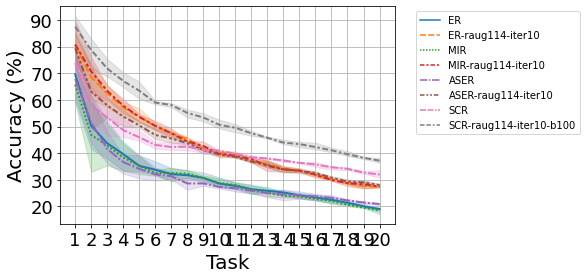

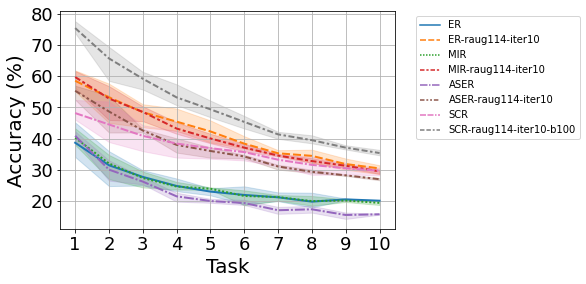

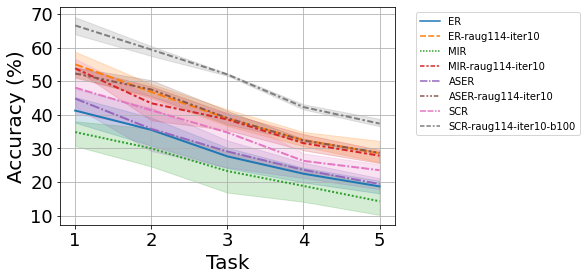

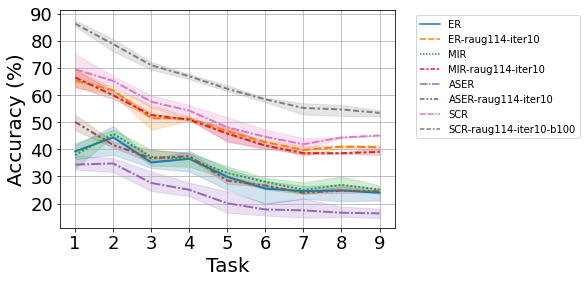

In [8]:
datasets=["cifar100","mini_imagenet","clrs25","core50","cifar10"]
res_list=[]
for i in [0,1,2,3]:#3,4]:
    dataset=datasets[i]
    mem_size=2000
    task_num=TASK_DICT[dataset]
    algo_name=[

              "ER",             
               "ER-raug114-iter10",              
              "MIR",
              "MIR-raug114-iter10",
               "ASER",
               "ASER-raug114-iter10"   ,
                "SCR",
               "SCR-raug114-iter10-b100",

              ]
    algo_list=from_name_to_algo_list(algo_name,mem_size)

    ################################    
    acc_list_seed=[]

    acc_list=[]

    for folder in ["1259051/","1259052/","1259053/",]:

        plot_setting['title_prefix']=dataset #+" seed "+folder[:-1] 
        data_prefix_list = get_data_prefix(algo_list,algo_name,dataset+"_",FOLDER_NAME=folder,)
        
        acc_list,fgt_list,pls_list = accuracy_analysis(algo_name,data_prefix_list,plot_setting,heatmap=False,id=0,split_flag=False,PLOT=False)
      

        acc_list_seed.append(acc_list)

    plot_random_seed_res(acc_list_seed,modify_algo_name=algo_name)
   
    mean,std = multiple_run_stats(acc_list_seed,algo_name,) 
    res=pd.DataFrame({"mean_"+dataset[:4]:mean,"std_"+dataset[:4]:std},index=[algo_name])
    res_list.append(res)

# res_main=pd.concat(res_list,axis=1)
# #res_main.to_csv("csv/main_results_5k.csv")

# Ablation study: aug/iteration

-------------
ER                          end acc: 0.182 forgetting 0.201    bwt:    -0.189   cur_task acc: 0.371
ER-raug0-iter2              end acc: 0.193 forgetting 0.319    bwt:    -0.300   cur_task acc: 0.494
ER-raug0-iter5              end acc: 0.175 forgetting 0.402    bwt:    -0.382   cur_task acc: 0.557
ER-raug0-iter10             end acc: 0.166 forgetting 0.430    bwt:    -0.409   cur_task acc: 0.575
ER-raug0-iter20             end acc: 0.138 forgetting 0.408    bwt:    -0.388   cur_task acc: 0.526
ER-raug114-iter1            end acc: 0.187 forgetting 0.082    bwt:    -0.068   cur_task acc: 0.256
ER-raug114-iter2            end acc: 0.244 forgetting 0.143    bwt:    -0.133   cur_task acc: 0.377
ER-raug114-iter5            end acc: 0.280 forgetting 0.298    bwt:    -0.283   cur_task acc: 0.564
ER-raug114-iter10           end acc: 0.277 forgetting 0.399    bwt:    -0.379   cur_task acc: 0.657
ER-raug114-iter20           end acc: 0.271 forgetting 0.457    bwt:    -0.434   cur_ta

/tmp/ipykernel_1590567/1494545634.py:196: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(list(np.arange(1,task_num+1)))


ER                                  19.04 0.613
ER-raug0-iter2                      19.02 0.249
ER-raug0-iter5                      17.25 0.189
ER-raug0-iter10                     16.08 0.489
ER-raug0-iter20                     14.83 0.762
ER-raug114-iter1                    18.64 0.674
ER-raug114-iter2                    25.04 1.018
ER-raug114-iter5                    27.81 0.652
ER-raug114-iter10                   27.37 0.305
ER-raug114-iter20                   27.32 0.530
ER-raug214-iter1                    12.69 0.127
ER-raug214-iter2                    24.18 1.550
ER-raug214-iter5                    28.81 0.716
ER-raug214-iter10                   28.69 0.172
ER-raug214-iter20                   29.03 0.458
-------------
ER                          end acc: 0.200 forgetting 0.080    bwt:    -0.068   cur_task acc: 0.268
ER-raug0-iter2              end acc: 0.230 forgetting 0.146    bwt:    -0.123   cur_task acc: 0.354
ER-raug0-iter5              end acc: 0.213 forgetting 0.282    bwt

/tmp/ipykernel_1590567/1494545634.py:196: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(list(np.arange(1,task_num+1)))


ER                                  20.05 0.044
ER-raug0-iter2                      23.26 0.378
ER-raug0-iter5                      20.36 0.862
ER-raug0-iter10                     17.83 0.645
ER-raug0-iter20                     16.49 0.176
ER-raug114-iter1                    15.43 1.005
ER-raug114-iter2                    23.33 0.611
ER-raug114-iter5                    29.08 0.876
ER-raug114-iter10                   30.42 1.325
ER-raug114-iter20                   30.31 0.674
ER-raug214-iter1                    10.72 0.817
ER-raug214-iter2                    19.79 4.143
ER-raug214-iter5                    27.74 1.059
ER-raug214-iter10                   30.49 0.846
ER-raug214-iter20                   31.86 1.291
-------------
ER                          end acc: 0.191 forgetting 0.097    bwt:    -0.077   cur_task acc: 0.268
ER-raug0-iter2              end acc: 0.216 forgetting 0.131    bwt:    -0.105   cur_task acc: 0.321
ER-raug0-iter5              end acc: 0.272 forgetting 0.097    bwt

/tmp/ipykernel_1590567/1494545634.py:196: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(list(np.arange(1,task_num+1)))


ER                                  18.68 1.557
ER-raug0-iter2                      21.31 0.229
ER-raug0-iter5                      26.54 1.511
ER-raug0-iter10                     27.77 1.496
ER-raug0-iter20                     28.65 0.107
ER-raug114-iter1                    14.72 1.905
ER-raug114-iter2                    18.97 0.913
ER-raug114-iter5                    24.17 0.691
ER-raug114-iter10                   28.56 2.691
ER-raug114-iter20                   32.30 1.067
ER-raug214-iter1                    8.536 3.386
ER-raug214-iter2                    13.17 6.525
ER-raug214-iter5                    21.23 1.501
ER-raug214-iter10                   26.38 1.807
ER-raug214-iter20                   31.69 1.171
-------------
ER                          end acc: 0.253 forgetting 0.091    bwt:    -0.066   cur_task acc: 0.320
ER-raug0-iter2              end acc: 0.250 forgetting 0.086    bwt:    -0.073   cur_task acc: 0.324
ER-raug0-iter5              end acc: 0.295 forgetting 0.098    bwt

/tmp/ipykernel_1590567/1494545634.py:196: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(list(np.arange(1,task_num+1)))


ER                                  24.01 2.043
ER-raug0-iter2                      25.67 0.613
ER-raug0-iter5                      27.85 2.232
ER-raug0-iter10                     28.12 1.570
ER-raug0-iter20                     27.74 1.240
ER-raug114-iter1                    31.50 0.257
ER-raug114-iter2                    34.38 0.371
ER-raug114-iter5                    39.60 1.200
ER-raug114-iter10                   40.78 0.740
ER-raug114-iter20                   41.43 1.048
ER-raug214-iter1                    28.87 0.564
ER-raug214-iter2                    32.92 1.266
ER-raug214-iter5                    44.10 2.666
ER-raug214-iter10                   45.49 2.282
ER-raug214-iter20                   46.41 0.716


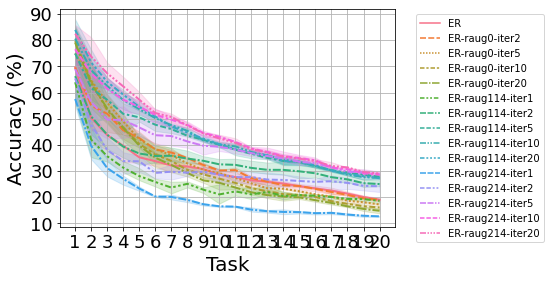

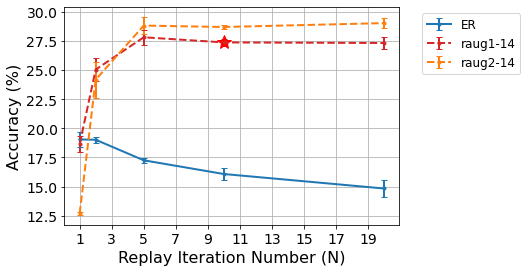

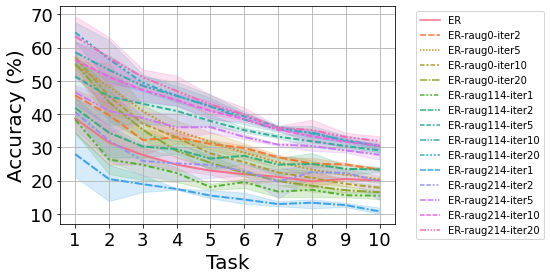

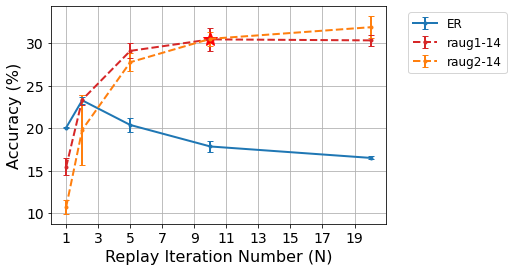

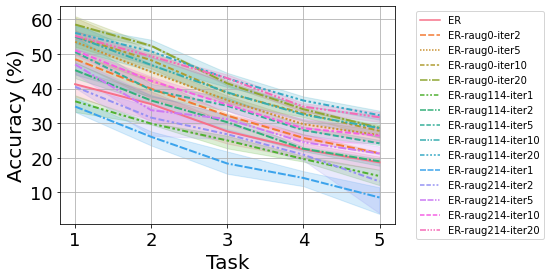

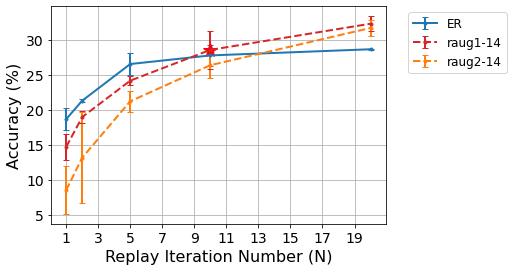

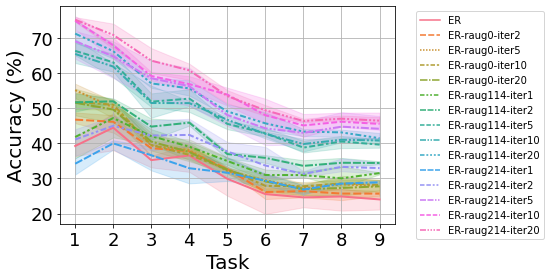

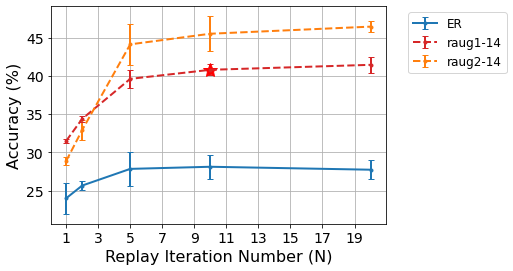

In [20]:
datasets=["cifar100","mini_imagenet","clrs25","core50","cifar10"]
res_list=[]
for i in [0,1,2,3]:
    dataset=datasets[i]
    mem_size=2000
    task_num=TASK_DICT[dataset]
    algo_name=[

              "ER",             
              "ER-raug0-iter2",
              "ER-raug0-iter5",
              "ER-raug0-iter10",              
              "ER-raug0-iter20", 
              "ER-raug114-iter1",
              "ER-raug114-iter2",
              "ER-raug114-iter5",
              "ER-raug114-iter10",              
              "ER-raug114-iter20",            
              "ER-raug214-iter1",
              "ER-raug214-iter2",
              "ER-raug214-iter5",
              "ER-raug214-iter10",
              "ER-raug214-iter20",
              ]
    algo_list=from_name_to_algo_list(algo_name,mem_size)

    ################################    
    acc_list_seed=[]

    acc_list=[]

    for folder in ["1259051/","1259052/","1259053/",]:

        plot_setting['title_prefix']=dataset #+" seed "+folder[:-1] 
        data_prefix_list = get_data_prefix(algo_list,algo_name,dataset+"_",FOLDER_NAME=folder,)
        
        acc_list,fgt_list,pls_list = accuracy_analysis(algo_name,data_prefix_list,plot_setting,heatmap=False,id=0,split_flag=False,PLOT=False)
      

        acc_list_seed.append(acc_list)

    plot_random_seed_res(acc_list_seed,modify_algo_name=algo_name)
   
    mean,std = multiple_run_stats(acc_list_seed,algo_name,) 
    res=pd.DataFrame({"mean_"+dataset[:4]:mean,"std_"+dataset[:4]:std},index=[algo_name])
    res_list.append(res)

    plot_aug_para(acc_list_seed,dataset) 
